### Protein Family Classification

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import pickle
from tqdm import tqdm

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
family_classification_metadata = pd.read_table('data/family_classification_metadata.tab')
family_classification_sequences = pd.read_table('data/family_classification_sequences.tab')

In [3]:
family_classification_metadata.head()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
0,Q6GZX4,001R_FRG3G,Putative transcription factor 001R,Pox_VLTF3,Poxvirus Late Transcription Factor VLTF3 like
1,Q6GZX3,002L_FRG3G,Uncharacterized protein 002L,DUF230,Poxvirus proteins of unknown function
2,Q6GZX0,005R_FRG3G,Uncharacterized protein 005R,US22,US22 like
3,Q91G88,006L_IIV6,Putative KilA-N domain-containing protein 006L,DUF3627,Protein of unknown function (DUF3627)
4,Q197F3,007R_IIV3,Uncharacterized protein 007R,DUF2738,Protein of unknown function (DUF2738)


In [4]:
family_classification_sequences.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [5]:
family_classification_metadata.describe()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
count,324018,324018,324018,324018,324018
unique,287308,295671,56951,7027,6967
top,Q1X881,POLG_DEN2P,UvrABC system protein B,MMR_HSR1,50S ribosome-binding GTPase
freq,16,12,1500,3084,3084


#### Task:
    
Use your ProtVec embedding from homework 5 to perform protein family classification using RNN.

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

* use 1000 most frequent families for classification
* validate your results on the train-test split
* reduce the dimensionality of the protein-space using Stochastic Neighbor Embedding and visualize two most frequent classes
* compare your RNN results with SVM
* visualization and metrics are up to you

In [6]:
NUM_CLASSES = 500

In [7]:
from  collections import Counter

cntr = Counter()
for p in family_classification_metadata['FamilyID']:
    cntr[p] += 1

family_ind = dict()
for idx, (family, _) in enumerate(cntr.most_common(NUM_CLASSES)):
    family_ind[family] = idx
    

print(dict(list(family_ind.items())[-10:]))

{'Phos_pyr_kin': 490, 'FliE': 491, 'RdgC': 492, 'MTS_N': 493, 'AstB': 494, 'CxxCxxCC': 495, 'DUF576': 496, 'PsbM': 497, 'Methyltransf_10': 498, 'RasGEF': 499}


In [8]:
embed_matrix = pd.read_csv('data/protVec_100d_3grams.csv', sep='\\t', header=None, index_col=0,  engine='python')

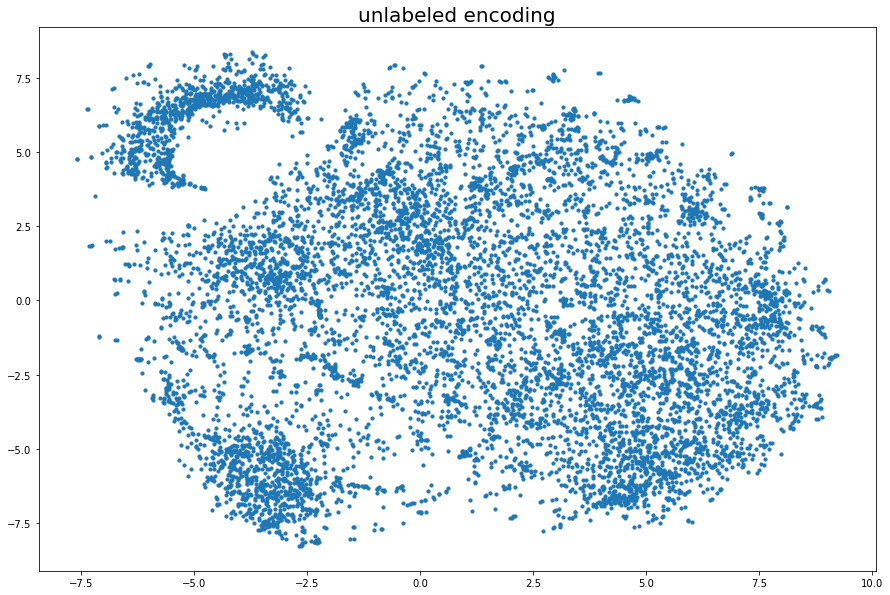

In [10]:
tsne = TSNE(n_components=2, random_state=13)
tsne_df = pd.DataFrame(tsne.fit_transform(embed_matrix), columns=['x0', 'x1'])

plt.figure(figsize=(15, 10))
plt.title('unlabeled encoding', fontsize=20)
plt.scatter(tsne_df.x0, tsne_df.x1, s=10)

In [11]:
MAX_PROTEIN_LEN = 600
VECTOR_LEN = 100
BATCH_SIZE = 128

In [12]:
proteins = np.array(family_classification_sequences['Sequences'])
families = np.array(family_classification_metadata['FamilyID'])

In [13]:
filtered = np.array([i for i in range(proteins.shape[0]) if len(proteins[i]) <= MAX_PROTEIN_LEN and families[i] in family_ind])
np.random.shuffle(filtered)

In [14]:
ratio = 0.8
split = int(filtered.shape[0] * ratio)
train, test = filtered[ : split], filtered[split : ]

In [15]:
def process(protein, embed_matrix):
    embeded = np.array([embed_matrix.loc[protein[i: i + 3] if protein[i: i + 3] in embed_matrix.index else '<unk>'] for i in range(0, len(protein) - 3, 3)])
    if (embeded.shape[0] < MAX_PROTEIN_LEN / 3):
        embeded = np.vstack((embeded, np.zeros(shape=(MAX_PROTEIN_LEN - embeded.shape[0], VECTOR_LEN))))
    return embeded


def process_proteins(proteins, embed_matrix):
    return np.array([process(proteins[i], embed_matrix) for i in tqdm(range(proteins.shape[0]))])
        
    
def process_families(families, family_ind):    
    return np.eye(NUM_CLASSES)[np.array([ family_ind[families[i]] for i in range(families.shape[0])])]
        
    
def generate_batch(proteins, families, embed_matrix, family_ind, train):
    while True:
        batch = np.random.choice(train, BATCH_SIZE)
        yield process_proteins(proteins[batch], embed_matrix), process_families(families[batch], family_ind)
        
        
def generate_test(proteins, families, embed_matrix, family_ind, test):  
    for i in range(0, test.shape[0], BATCH_SIZE):
        batch = test[i: i + BATCH_SIZE]
        yield process_proteins(proteins[batch], embed_matrix), process_families(families[batch], family_ind)


In [16]:
from lazy import lazy

class SequenceClassificationModel:
    def __init__(self, params):
        self.params = params
        self._create_placeholders()
        self.prediction
        self.cost
        self.error
        self.optimize
        self._create_summaries()
    
    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.data = tf.placeholder(tf.float32, [None, self.params.seq_length, self.params.embed_length])
            self.target = tf.placeholder(tf.float32, [None, NUM_CLASSES])
            self.target
  
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar('loss', self.cost)
            tf.summary.scalar('erroe', self.error)
            self.summary = tf.summary.merge_all()
            saver = tf.train.Saver()
            
    @lazy
    def length(self):
    # First, we obtain the lengths of sequences in the current data batch. We need this since
    # the data comes as a single tensor, padded with zero vectors to the longest review length.
    # Instead of keeping track of the sequence lengths of every review, we just compute it
    # dynamically in TensorFlow.
    
        with tf.name_scope("seq_length"):
            used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
            length = tf.reduce_sum(used, reduction_indices=1)
            length = tf.cast(length, tf.int32)
        return length
    
    @lazy
    def prediction(self):
    # Note that the last relevant output activation of the RNN has a different index for each
    # sequence in the training batch. This is because each review has a different length. We
    # already know the length of each sequence.
    # The problem is that we want to index in the dimension of time steps, which is
    # the second dimension in the batch of shape  (sequences, time_steps, word_vectors) .
    
        with tf.name_scope("recurrent_layer"):
            output, _ = tf.nn.dynamic_rnn(
                self.params.rnn_cell(self.params.rnn_hidden),
                self.data,
                dtype=tf.float32,
                sequence_length=self.length
            )
        last = self._last_relevant(output, self.length)

        with tf.name_scope("softmax_layer"):
            num_classes = int(self.target.get_shape()[1])
            weight = tf.Variable(tf.truncated_normal(
                [self.params.rnn_hidden, num_classes], stddev=0.01))
            bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
            prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
        return prediction
    
    @lazy
    def cost(self):
        cross_entropy = -tf.reduce_sum(self.target * tf.log(self.prediction))
        return cross_entropy
    
    @lazy
    def error(self):
        self.mistakes = tf.not_equal(
            tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
        return tf.reduce_mean(tf.cast(self.mistakes, tf.float32))
    
    @lazy
    def optimize(self):
    # RNNs are quite hard to train and weights tend to diverge if the hyper parameters do not
    # play nicely together. The idea of gradient clipping is to restrict the the values of the
    # gradient to a sensible range. This way, we can limit the maximum weight updates.

        with tf.name_scope("optimization"):
            gradient = self.params.optimizer.compute_gradients(self.cost)
            if self.params.gradient_clipping:
                limit = self.params.gradient_clipping
                gradient = [
                    (tf.clip_by_value(g, -limit, limit), v)
                    if g is not None else (None, v)
                    for g, v in gradient]
            optimize = self.params.optimizer.apply_gradients(gradient)
        return optimize
    
    @staticmethod
    def _last_relevant(output, length):
        with tf.name_scope("last_relevant"):
            # As of now, TensorFlow only supports indexing along the first dimension, using
            # tf.gather() . We thus flatten the first two dimensions of the output activations from their
            # shape of  sequences x time_steps x word_vectors  and construct an index into this resulting tensor.
            batch_size = tf.shape(output)[0]
            max_length = int(output.get_shape()[1])
            output_size = int(output.get_shape()[2])

            # The index takes into account the start indices for each sequence in the flat tensor and adds
            # the sequence length to it. Actually, we only add  length - 1  so that we select the last valid
            # time step.
            index = tf.range(0, batch_size) * max_length + (length - 1)
            flat = tf.reshape(output, [-1, output_size])
            relevant = tf.gather(flat, index)
        return relevant

In [17]:
from attrdict import AttrDict

params = AttrDict(
    rnn_cell=tf.contrib.rnn.GRUCell,
    rnn_hidden=256,
    optimizer=tf.train.AdamOptimizer(0.001),
    batch_size=BATCH_SIZE,
    gradient_clipping=100,
    seq_length=MAX_PROTEIN_LEN,
    embed_length=VECTOR_LEN
)

In [30]:
tf.reset_default_graph()
model = SequenceClassificationModel(params)

/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [42]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.33)

NUM_ITER = 5000

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    saver = tf.train.Saver()
    save_path = 'checkpoints/5k'

    sess.run(tf.global_variables_initializer())
    
    batch_generator = generate_batch(proteins, families, embed_matrix, family_ind, train)
    
    for index, batch in enumerate(batch_generator):
        feed = {model.data: batch[0], model.target: batch[1]}
        cost, error, _, summary_str = sess.run([model.cost, model.error, model.optimize, model.summary], feed) 
        if index % 10 == 0:
            print('{}: {:3.1f}% loss={}'.format(index, 100 * (1 - error), cost))
        if index % 100 == 0:
            saver.save(sess, save_path, index)
        if index == NUM_ITER:
            break
            
    test_generator = generate_test(proteins, families, embed_matrix, family_ind, test)
    
    mean_error = 0
    
    print('==== run test ====')
    
    for index, batch in enumerate(test_generator):
        feed = {model.data: batch[0], model.target: batch[1]}
        mean_error += sess.run(model.error, feed)
    
    print('Test accuracy: {:3.1f}%'.format(100 * (1 - mean_error / (test.shape[0]/BATCH_SIZE))))

0: 0.0% loss=795.5059204101562
10: 3.1% loss=767.6068115234375
20: 1.6% loss=765.532470703125
30: 0.8% loss=765.8539428710938
40: 3.1% loss=749.03076171875
50: 0.8% loss=759.7646484375
60: 0.0% loss=751.7271728515625
70: 3.9% loss=737.5298461914062
80: 3.1% loss=750.0874633789062
90: 0.8% loss=729.7315673828125
100: 3.9% loss=705.7344970703125
110: 4.7% loss=670.9608764648438
120: 1.6% loss=681.9158325195312
130: 1.6% loss=672.687744140625
140: 0.0% loss=679.6766357421875
150: 3.9% loss=625.4700317382812
160: 6.2% loss=637.878173828125
170: 2.3% loss=651.47607421875
180: 2.3% loss=626.3045654296875
190: 3.1% loss=627.642822265625
200: 4.7% loss=619.7959594726562
210: 7.8% loss=619.2700805664062
220: 11.7% loss=590.71533203125
230: 4.7% loss=596.2481689453125
240: 9.4% loss=587.7886962890625
250: 5.5% loss=585.2278442382812
260: 7.0% loss=589.977783203125
270: 7.0% loss=592.4888916015625
280: 7.8% loss=554.9534912109375
290: 10.9% loss=560.8040771484375
300: 17.2% loss=520.419677734375


2380: 67.2% loss=189.67935180664062
2390: 75.8% loss=162.622802734375
2400: 68.8% loss=201.44895935058594
2410: 66.4% loss=186.6343994140625
2420: 71.9% loss=158.2175750732422
2430: 73.4% loss=151.92173767089844
2440: 71.1% loss=196.45921325683594
2450: 68.0% loss=209.3799591064453
2460: 74.2% loss=151.473388671875
2470: 72.7% loss=166.62684631347656
2480: 72.7% loss=180.3177490234375
2490: 72.7% loss=171.60035705566406
2500: 68.0% loss=208.06556701660156
2510: 75.0% loss=148.19288635253906
2520: 70.3% loss=164.18179321289062
2530: 68.8% loss=182.85032653808594
2540: 71.1% loss=196.6788787841797
2550: 78.1% loss=152.7959747314453
2560: 71.1% loss=159.0670166015625
2570: 65.6% loss=208.5914306640625
2580: 71.1% loss=175.99913024902344
2590: 71.1% loss=161.89935302734375
2600: 75.0% loss=172.8799285888672
2610: 73.4% loss=176.7971954345703
2620: 68.8% loss=190.45401000976562
2630: 71.1% loss=163.12100219726562
2640: 73.4% loss=172.0245361328125
2650: 70.3% loss=155.72071838378906
2660: 7

4690: 76.6% loss=118.26945495605469
4700: 85.2% loss=89.34673309326172
4710: 82.8% loss=91.05410766601562
4720: 75.8% loss=123.87410736083984
4730: 82.8% loss=120.95664978027344
4740: 82.8% loss=85.84756469726562
4750: 91.4% loss=56.04483413696289
4760: 84.4% loss=98.21630859375
4770: 86.7% loss=67.30035400390625
4780: 81.2% loss=96.6190185546875
4790: 80.5% loss=110.74629974365234
4800: 89.1% loss=68.08314514160156
4810: 85.2% loss=93.78766632080078
4820: 81.2% loss=112.33625793457031
4830: 89.8% loss=65.93739318847656
4840: 86.7% loss=68.99078369140625
4850: 83.6% loss=81.39811706542969
4860: 87.5% loss=74.59770202636719
4870: 78.9% loss=135.48785400390625
4880: 83.6% loss=100.4899673461914
4890: 81.2% loss=117.5702133178711
4900: 82.8% loss=85.4014663696289
4910: 79.7% loss=102.37327575683594
4920: 82.8% loss=83.08001708984375
4930: 86.7% loss=72.66152954101562
4940: 89.1% loss=77.59556579589844
4950: 81.2% loss=92.18267059326172
4960: 82.0% loss=102.58865356445312
4970: 79.7% loss=

# RandomForestClassifier

In [18]:
def process(protein, embed_matrix):
    embeded = np.array([embed_matrix.loc[protein[i: i + 3] if protein[i: i + 3] in embed_matrix.index else '<unk>'] for i in range(0, len(protein) - 3, 3)])
    return np.sum(embeded, axis = 0)

In [19]:
prot_train = process_proteins(proteins[train], embed_matrix)
fam_train = process_families(families[train], family_ind)

100%|██████████| 147766/147766 [1:08:53<00:00, 35.75it/s]


In [20]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators=16, max_depth=128)
RFC.fit(prot_train, fam_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=128, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=16, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [21]:
fam_test = process_families(families[test], family_ind)
prot_test = process_proteins(proteins[test], embed_matrix)

100%|██████████| 36942/36942 [38:56<00:00, 15.81it/s] 


In [22]:
RFC.score(prot_test, fam_test)

0.42325808023388012

# picture

In [43]:
labels = fam_train.dot(np.array(range(len(fam_train[0, :]))))

q = Counter(labels)
print(q.most_common(2))

[(0.0, 2379), (2.0, 1878)]


In [44]:
ind = np.logical_or(labels == 0, labels == 2).squeeze()
prot_embed = tsne.fit_transform(prot_train[ind])

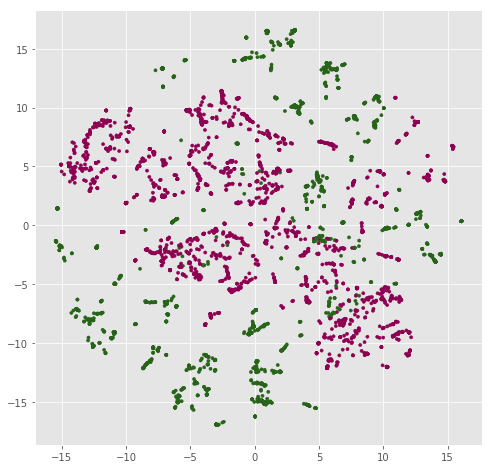

In [53]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 8))
plt.scatter(prot_embed[:, 0], prot_embed[:, 1], c=labels[ind], s=10, cmap=plt.cm.PiYG)